Max horizontal distance: 1908.5539028280025
Min horizontal distance: 1574.1537409033465


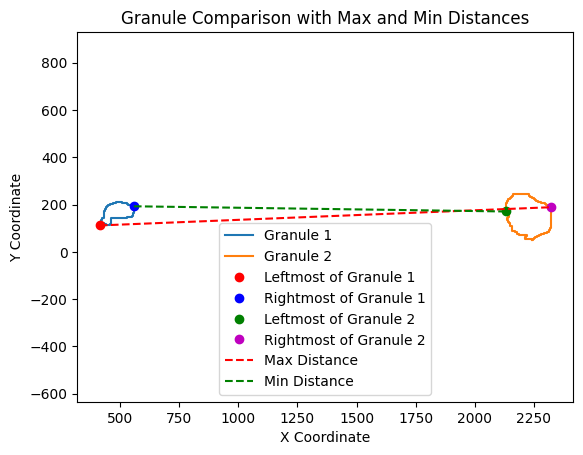

Database connection closed.


In [1]:
import psycopg2
from shapely.wkb import loads as load_wkb
from shapely.wkt import loads as load_wkt
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

# Setting up the database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# IDs of the granules I'm comparing
granule_id1 = 1  # ID for the first granule
granule_id2 = 2  # ID for the second granule

# Specifying the table where the granule data is stored
granule_table = 'uniform_granule'

try:
    # Connecting to the database
    connection = psycopg2.connect(
        host=host,
        port=port,
        database=database,
        user=user,
        password=password
    )
    cursor = connection.cursor()

    # Query to get the geometry of the first granule
    cursor.execute(f"SELECT ST_AsEWKB(shape) FROM {granule_table} WHERE id = %s", (granule_id1,))
    granule_a_geom_wkb = cursor.fetchone()[0]

    # Query to get the geometry of the second granule
    cursor.execute(f"SELECT ST_AsEWKB(shape) FROM {granule_table} WHERE id = %s", (granule_id2,))
    granule_b_geom_wkb = cursor.fetchone()[0]

    # Converting the binary geometry data into a Shapely geometry
    granule_a_geom = load_wkb(bytes(granule_a_geom_wkb))
    granule_b_geom = load_wkb(bytes(granule_b_geom_wkb))

    # Helper function to find the leftmost and rightmost points of a granule
    def get_extreme_points(geom):
        points = list(geom.exterior.coords)  # Extract all the points from the boundary
        leftmost_point = min(points, key=lambda p: p[0])  # Point with the smallest x-coordinate
        rightmost_point = max(points, key=lambda p: p[0])  # Point with the largest x-coordinate
        return leftmost_point, rightmost_point

    # Getting the extreme points for the first granule
    leftmost_point_a, rightmost_point_a = get_extreme_points(granule_a_geom)

    # Getting the extreme points for the second granule
    leftmost_point_b, rightmost_point_b = get_extreme_points(granule_b_geom)

    # Calculate distances
    max_distance = Point(leftmost_point_a).distance(Point(rightmost_point_b))
    min_distance = Point(rightmost_point_a).distance(Point(leftmost_point_b))

    # Printing out the calculated distances
    print(f"Max horizontal distance: {max_distance}")
    print(f"Min horizontal distance: {min_distance}")

    # Setting up the visualization
    fig, ax = plt.subplots()

    # Plotting the first granule
    x_a, y_a = granule_a_geom.exterior.xy
    ax.plot(x_a, y_a, label=f'Granule {granule_id1}')

    # Plotting the second granule
    x_b, y_b = granule_b_geom.exterior.xy
    ax.plot(x_b, y_b, label=f'Granule {granule_id2}')

    # Marking the extreme points for each granule
    ax.plot(*leftmost_point_a, 'ro', label=f'Leftmost of Granule {granule_id1}')
    ax.plot(*rightmost_point_a, 'bo', label=f'Rightmost of Granule {granule_id1}')
    ax.plot(*leftmost_point_b, 'go', label=f'Leftmost of Granule {granule_id2}')
    ax.plot(*rightmost_point_b, 'mo', label=f'Rightmost of Granule {granule_id2}')

    # Drawing lines to represent the distances
    max_line = LineString([leftmost_point_a, rightmost_point_b])
    x_max_line, y_max_line = max_line.xy
    ax.plot(x_max_line, y_max_line, 'r--', label='Max Distance')

    min_line = LineString([rightmost_point_a, leftmost_point_b])
    x_min_line, y_min_line = min_line.xy
    ax.plot(x_min_line, y_min_line, 'g--', label='Min Distance')

    # Adding labels and finishing up the plot
    ax.set_title('Granule Comparison with Max and Min Distances')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend()
    ax.axis('equal')

    # Display the plot (optional)
    plt.show()

except Exception as error:
    # Catching any issues that might come up
    print(f"Error: {error}")

finally:
    # Cleaning up and closing the connection
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        print("Database connection closed.")


The nearest granule to tracked_id 7459 (uniform_granule) at 2022-05-26 17:46:29 is tracked_id 5662 (complex_granule) with a distance of 18.439088914585774


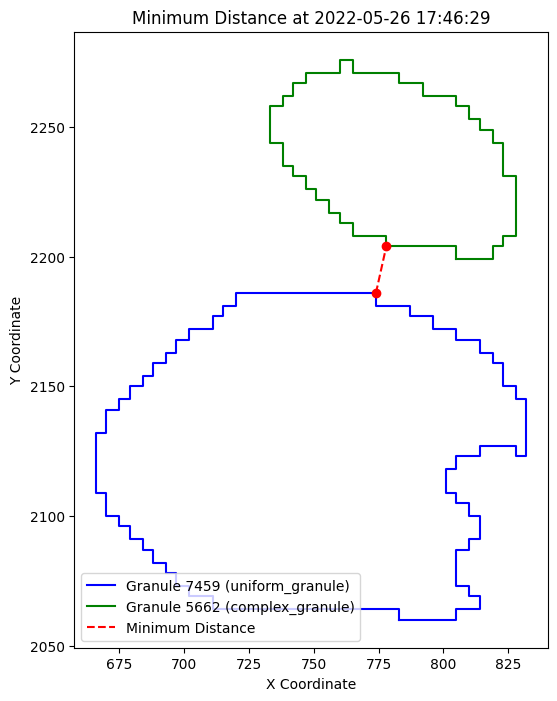

Database connection closed.


In [2]:
import psycopg2
from shapely.wkb import loads as load_wkb
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from datetime import datetime

# Database connection parameters
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# The granule I’m analyzing
granule_tracked_id = 7459  # Replace with the specific granule's tracked_id
granule_time_str = "2022-05-26 17:46:29"  # Time of interest
granule_time = datetime.strptime(granule_time_str, "%Y-%m-%d %H:%M:%S")

try:
    # Setting up the database connection
    connection = psycopg2.connect(
        host=host, port=port, database=database, user=user, password=password
    )
    cursor = connection.cursor()

    # Creating a unified view to simplify queries across all granule types
    create_view_query = """
    CREATE OR REPLACE VIEW all_granules AS
    SELECT id, time, tracked_id, shape, 'complex_granule' AS granule_type FROM complex_granule
    UNION ALL
    SELECT id, time, tracked_id, shape, 'granule_with_dot' AS granule_type FROM granule_with_dot
    UNION ALL
    SELECT id, time, tracked_id, shape, 'granule_with_lane' AS granule_type FROM granule_with_lane
    UNION ALL
    SELECT id, time, tracked_id, shape, 'uniform_granule' AS granule_type FROM uniform_granule;
    """
    cursor.execute(create_view_query)
    connection.commit()

    # Retrieving the geometry and type of the specific granule
    cursor.execute("""
        SELECT granule_type, ST_AsEWKB(shape) AS geom_wkb
        FROM all_granules
        WHERE tracked_id = %s AND time = %s AND shape IS NOT NULL;
    """, (granule_tracked_id, granule_time))
    result = cursor.fetchone()

    if result and result[1]:
        granule_type = result[0]  # Type of the granule
        geom_wkb = result[1]  # Geometry data
        # Converting the binary geometry to a usable format
        granule_geom = load_wkb(geom_wkb.tobytes() if isinstance(geom_wkb, memoryview) else geom_wkb)
    else:
        print(f"No granule found with tracked_id {granule_tracked_id} at time {granule_time_str}.")
        exit()

    # Getting geometries and types of all other granules at the same time
    cursor.execute("""
        SELECT tracked_id, granule_type, ST_AsEWKB(shape) AS geom_wkb
        FROM all_granules
        WHERE tracked_id <> %s AND time = %s AND shape IS NOT NULL;
    """, (granule_tracked_id, granule_time))
    other_granules = cursor.fetchall()

    # Setting up variables to track the nearest granule
    min_distance = None
    nearest_tracked_id = None
    nearest_geom = None
    nearest_granule_type = None

    # Looping through the other granules to determine the nearest one
    for other_tracked_id, other_granule_type, other_geom_wkb in other_granules:
        if other_geom_wkb:
            # Converting the geometry to a usable format
            other_geom = load_wkb(other_geom_wkb.tobytes() if isinstance(other_geom_wkb, memoryview) else other_geom_wkb)

            # Measuring the distance between the granules
            distance = granule_geom.distance(other_geom)

            # Updating the nearest granule if this one is closer
            if min_distance is None or distance < min_distance:
                min_distance = distance
                nearest_tracked_id = other_tracked_id
                nearest_geom = other_geom
                nearest_granule_type = other_granule_type

    if nearest_tracked_id is not None:
        print(f"The nearest granule to tracked_id {granule_tracked_id} ({granule_type}) at {granule_time_str} "
              f"is tracked_id {nearest_tracked_id} ({nearest_granule_type}) with a distance of {min_distance}")

        # Finding the closest points between the two geometries
        point1, point2 = nearest_points(granule_geom, nearest_geom)

        # Setting up the plot
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect('equal')

        # Drawing the granules
        x1, y1 = granule_geom.exterior.xy
        ax.plot(x1, y1, 'b-', label=f'Granule {granule_tracked_id} ({granule_type})')

        x2, y2 = nearest_geom.exterior.xy
        ax.plot(x2, y2, 'g-', label=f'Granule {nearest_tracked_id} ({nearest_granule_type})')

        # Marking the line of minimum distance
        ax.plot([point1.x, point2.x], [point1.y, point2.y], 'r--', label='Minimum Distance')

        # Highlighting the points of minimum distance
        ax.plot(point1.x, point1.y, 'ro')
        ax.plot(point2.x, point2.y, 'ro')

        # Adding title, labels, and legend
        ax.set_title(f'Minimum Distance at {granule_time_str}')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.legend()

        # Showing the plot
        plt.show()
    else:
        print(f"No nearest granule found for tracked_id {granule_tracked_id} at {granule_time_str}.")

except Exception as error:
    # Catching any errors that occur
    print(f"Error: {error}")

finally:
    # Closing the database connection
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        print("Database connection closed.")


Granule mergers between 2022-05-26 17:46:29 and 2022-05-26 17:46:35:
Granule 7543 at 2022-05-26 17:46:35 is a merger of granules [6917, 6834, 7529, 7525, 7543, 7497, 7379, 7542, 7427, 7423, 6396, 7526] from 2022-05-26 17:46:29
Granule 7540 at 2022-05-26 17:46:35 is a merger of granules [7511, 7540, 7508, 7507, 7443, 7515, 7512, 7510, 7403, 7436, 7440, 7504] from 2022-05-26 17:46:29
Granule 7541 at 2022-05-26 17:46:35 is a merger of granules [7413, 7519, 6524, 7516, 7513, 7541, 7410, 7354, 6614, 7416] from 2022-05-26 17:46:29
Granule 7452 at 2022-05-26 17:46:35 is a merger of granules [7284, 7045, 7452, 7427, 7431, 7545, 7552, 7342, 7356] from 2022-05-26 17:46:29
Granule 7500 at 2022-05-26 17:46:35 is a merger of granules [7316, 7500, 7316, 7234, 7502, 7461, 7500, 7431] from 2022-05-26 17:46:29
Granule 7465 at 2022-05-26 17:46:35 is a merger of granules [7464, 7410, 7410, 7465, 7438, 7464, 6655, 7465] from 2022-05-26 17:46:29
Granule 7550 at 2022-05-26 17:46:35 is a merger of granules [

/usr/local/lib/python3.10/dist-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/usr/local/lib/python3.10/dist-packages/geopandas/io/sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


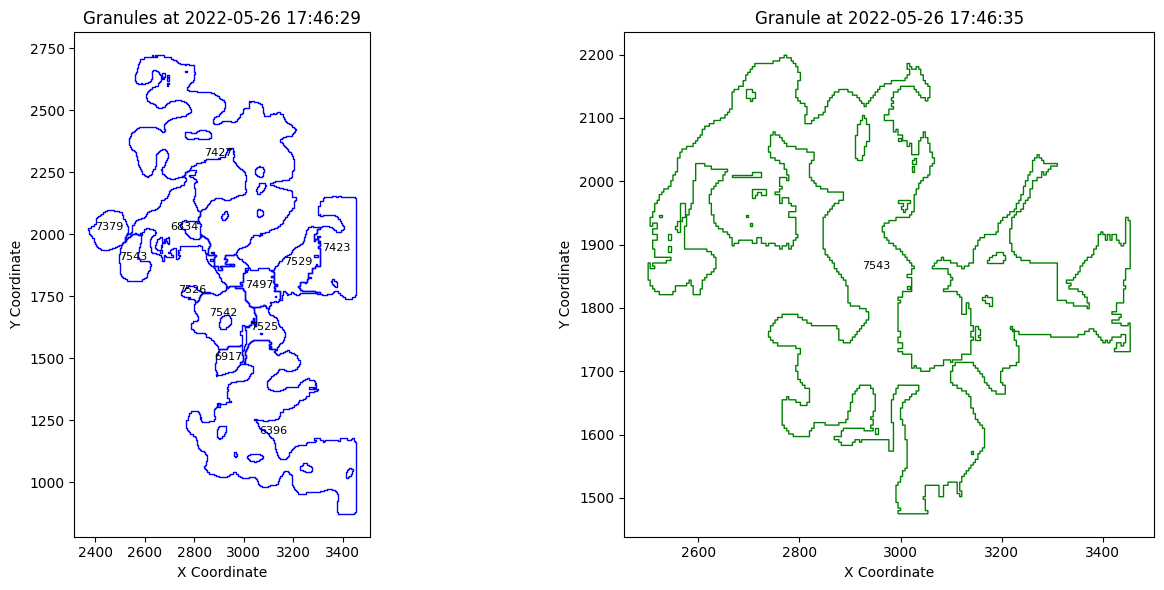

Database connection closed.


In [3]:
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt

# Setting up the database connection details
host = "150.230.166.174"
port = 5432
database = "dkist"
user = "dkist"
password = "sdbsdb!"

# Time periods I’m analyzing
time_t_str = "2022-05-26 17:46:29"  # Start time
time_t1_str = "2022-05-26 17:46:35"  # End time

try:
    # Establishing the database connection
    connection = psycopg2.connect(
        host=host, port=port, database=database, user=user, password=password
    )

    # Creating a unified view that combines all granule tables (helps keep things simple)
    with connection.cursor() as cursor:
        create_view_query = """
        CREATE OR REPLACE VIEW all_granules AS
        SELECT id, time, tracked_id, shape, 'complex_granule' AS granule_type FROM complex_granule
        UNION ALL
        SELECT id, time, tracked_id, shape, 'granule_with_dot' AS granule_type FROM granule_with_dot
        UNION ALL
        SELECT id, time, tracked_id, shape, 'granule_with_lane' AS granule_type FROM granule_with_lane
        UNION ALL
        SELECT id, time, tracked_id, shape, 'uniform_granule' AS granule_type FROM uniform_granule;
        """
        cursor.execute(create_view_query)
        connection.commit()

    # Querying for granules that merged at time t+1
    mergers_query = """
    WITH current_granules AS (
        SELECT tracked_id, shape
        FROM all_granules
        WHERE time = %s AND shape IS NOT NULL
    ),
    next_granules AS (
        SELECT tracked_id, shape
        FROM all_granules
        WHERE time = %s AND shape IS NOT NULL
    )
    SELECT
        ng.tracked_id AS next_tracked_id,
        array_agg(cg.tracked_id) AS merging_tracked_ids,
        COUNT(cg.tracked_id) AS merging_count
    FROM
        next_granules ng
    JOIN
        current_granules cg
    ON
        ST_Intersects(ng.shape, cg.shape)
    GROUP BY
        ng.tracked_id
    HAVING
        COUNT(cg.tracked_id) >= 2  -- Filtering for mergers involving 2 or more granules
    ORDER BY
        merging_count DESC;
    """

    # Executing the query to find mergers
    with connection.cursor() as cursor:
        cursor.execute(mergers_query, (time_t_str, time_t1_str))
        mergers = cursor.fetchall()

    if not mergers:
        print(f"No granule mergers found between {time_t_str} and {time_t1_str}.")
    else:
        print(f"Granule mergers between {time_t_str} and {time_t1_str}:")
        for next_tracked_id, merging_tracked_ids, merging_count in mergers:
            print(f"Granule {next_tracked_id} at {time_t1_str} is a merger of granules {merging_tracked_ids} from {time_t_str}")

        # Visualizing the first merger (if any)
        next_tracked_id = mergers[0][0]
        merging_tracked_ids = mergers[0][1]

        # Getting the geometries of the merging granules at time t
        granules_t_query = """
        SELECT tracked_id, shape
        FROM all_granules
        WHERE time = %s AND tracked_id = ANY(%s) AND shape IS NOT NULL;
        """
        granules_t_gdf = gpd.GeoDataFrame.from_postgis(
            granules_t_query,
            connection,
            geom_col='shape',
            params=[time_t_str, merging_tracked_ids],
            crs=None,
        )

        # Getting the geometry of the merged granule at time t+1
        granule_t1_query = """
        SELECT tracked_id, shape
        FROM all_granules
        WHERE time = %s AND tracked_id = %s AND shape IS NOT NULL;
        """
        granule_t1_gdf = gpd.GeoDataFrame.from_postgis(
            granule_t1_query,
            connection,
            geom_col='shape',
            params=[time_t1_str, next_tracked_id],
            crs=None,
        )

        # Setting up the plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].set_aspect('equal')
        axes[1].set_aspect('equal')

        # Plotting granules at time t
        granules_t_gdf.boundary.plot(ax=axes[0], color='blue', linewidth=1)
        axes[0].set_title(f'Granules at {time_t_str}')
        axes[0].set_xlabel('X Coordinate')
        axes[0].set_ylabel('Y Coordinate')
        for idx, row in granules_t_gdf.iterrows():
            x, y = row['shape'].centroid.coords[0]
            axes[0].text(x, y, str(row['tracked_id']), fontsize=8, ha='center')

        # Plotting the merged granule at time t+1
        granule_t1_gdf.boundary.plot(ax=axes[1], color='green', linewidth=1)
        axes[1].set_title(f'Granule at {time_t1_str}')
        axes[1].set_xlabel('X Coordinate')
        axes[1].set_ylabel('Y Coordinate')
        for idx, row in granule_t1_gdf.iterrows():
            x, y = row['shape'].centroid.coords[0]
            axes[1].text(x, y, str(row['tracked_id']), fontsize=8, ha='center')

        plt.tight_layout()
        plt.show()

except Exception as error:
    # Handling any errors during execution
    print(f"Error: {error}")

finally:
    # Closing the database connection
    if 'connection' in locals() and connection:
        connection.close()
        print("Database connection closed.")
